In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score

In [57]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv', index_col='id')
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0


# Feature Types:
- Nominal: gender, hypertension, heart_disease, ever_married, work_type, residence_type, smoking_status
- Numerical: age, avg_glucose_level, bmi

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


In [59]:
# Check for duplicate rows
df.duplicated().sum()

0

In [60]:
# Identify syntax errors in categorical data
pd.options.display.max_rows = 999
data_types = df.dtypes
str_cols = data_types[data_types == 'object'].index

for col in str_cols:
    print(f'- {col}:')
    print(df[col].value_counts(dropna=False)) # No errors
    print('\n\n')

- gender:
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64



- ever_married:
Yes    3353
No     1757
Name: ever_married, dtype: int64



- work_type:
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64



- Residence_type:
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64



- smoking_status:
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64





In [61]:
# Identify errors in numerical data
df.describe() # No errors

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [62]:
# Address missing values

# bmi is a numerical feature -> can impute mean or median
# median is imputed to reduce the effect of outliers
median_bmi = df['bmi'].median()
df['bmi'].fillna(value=median_bmi, inplace=True)
df.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

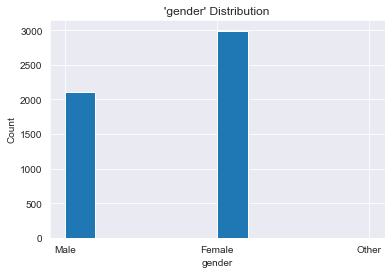

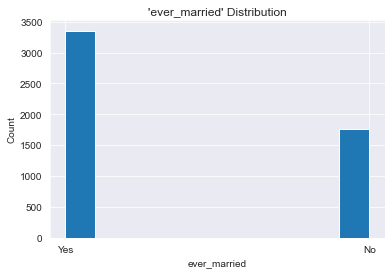

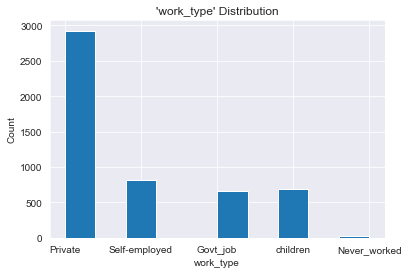

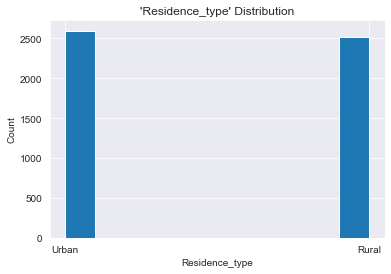

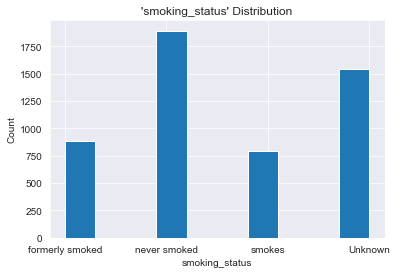

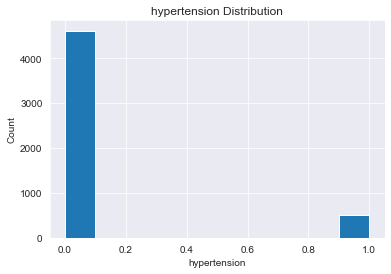

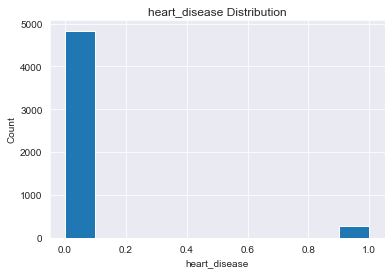

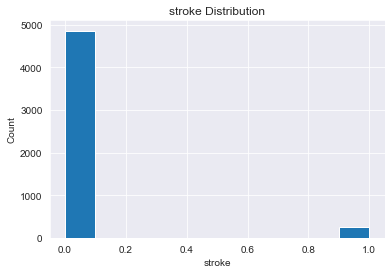

In [63]:
# View distributions of categorical features
sns.set_style('darkgrid')
for col in str_cols:
    df[f'{col}'].hist()
    plt.title(f"'{col}' Distribution")
    plt.ylabel('Count')
    plt.xlabel(f'{col}')
    plt.show()

df['hypertension'].hist()
plt.title("hypertension Distribution")
plt.ylabel('Count')
plt.xlabel('hypertension')
plt.show()

df['heart_disease'].hist()
plt.title("heart_disease Distribution")
plt.ylabel('Count')
plt.xlabel('heart_disease')
plt.show()

df['stroke'].hist()
plt.title("stroke Distribution")
plt.ylabel('Count')
plt.xlabel('stroke')
plt.show()

Few samples of patients with hypertension, heart_disease, or stroke are present

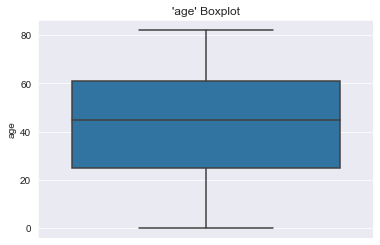

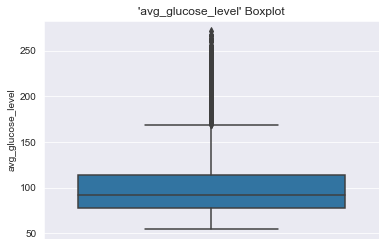

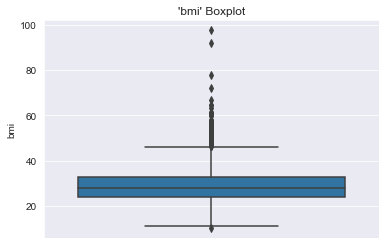

In [64]:
# View distributions of numerical features
num_cols = ['age', 'avg_glucose_level', 'bmi']

for col in num_cols:
    sns.boxplot(data=df, y=col)
    plt.title(f"'{col}' Boxplot")
    plt.show()

'avg_glucose_level' and 'bmi' contain many outliers

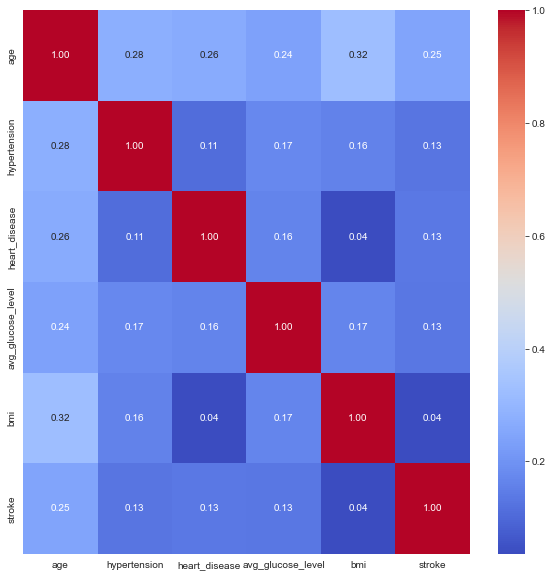

In [65]:
# View heatmap of correlations between features
corr = df.corr()

fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

The highest correlation found in the dataset is between bmi and age, with a correlation of 0.32.  The highest correlation between the target variable, stroke, and any of the numerical features is a correlation of 0.25 with age. Age is also weakly correlated with all of the other numerical features.

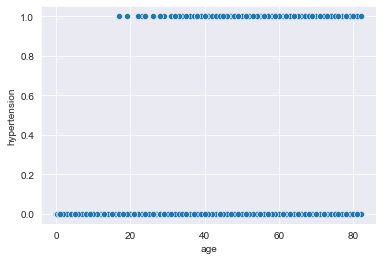

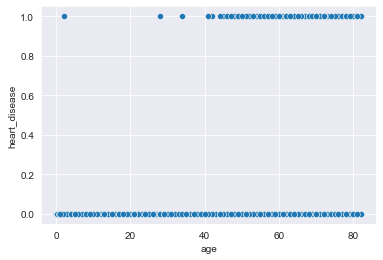

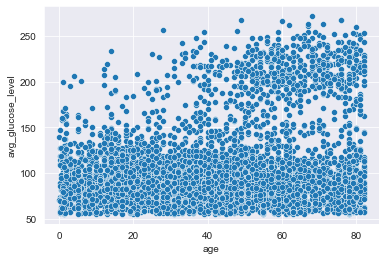

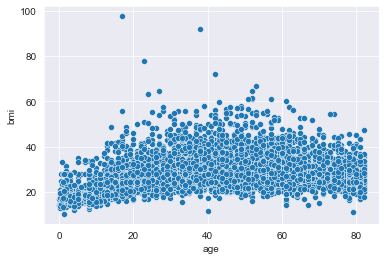

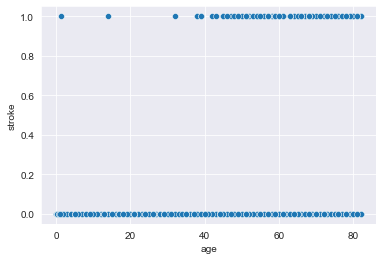

In [66]:
# Visualize correlations between age and other numerical features
cols = df.select_dtypes(include='number')
for col in cols:
    if col != 'age':
        sns.scatterplot(data=df, x='age', y=col)
        plt.show()

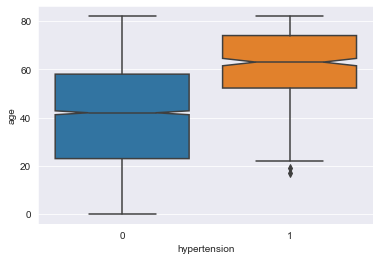

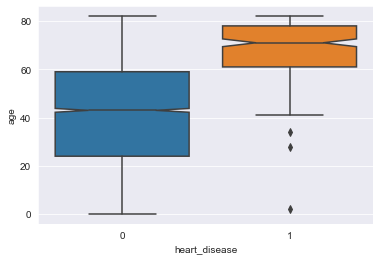

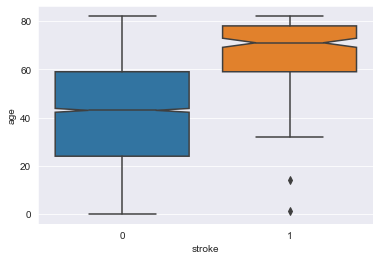

In [67]:
box_cols = ['hypertension', 'heart_disease', 'stroke']

for col in box_cols:
    sns.boxplot(data=df, y='age', x=col, notch=True)
    plt.show()

Those who have had hypertension, heart disease, or stroke are older, on average.

In [68]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

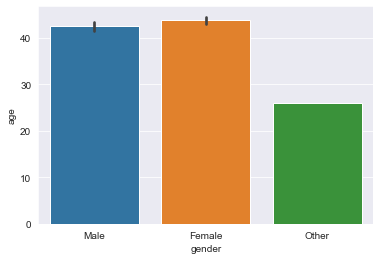

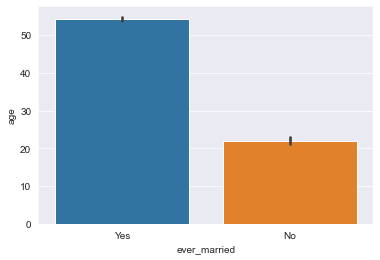

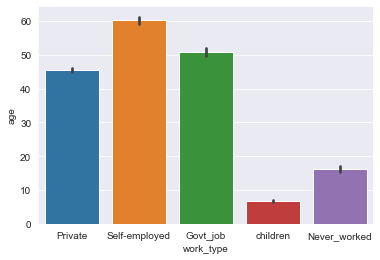

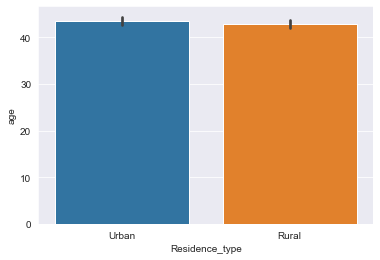

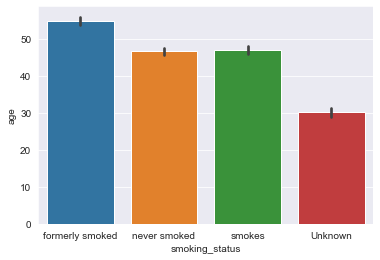

In [69]:
# Visualize correlations between age and other categorical features
cat_cols = df.select_dtypes(include='object')
for col in cat_cols:
    sns.barplot(data=df, y='age', x=col)
    plt.show()

Those who have been married are older, on average. Those who are self-employed are older, on average, and those who have never worked are younger, on average.

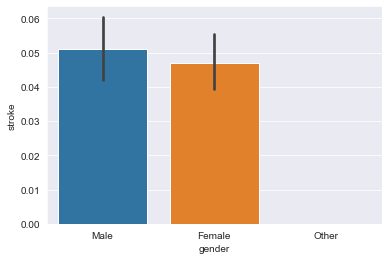

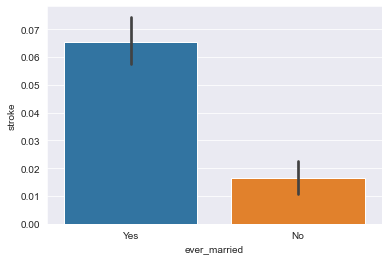

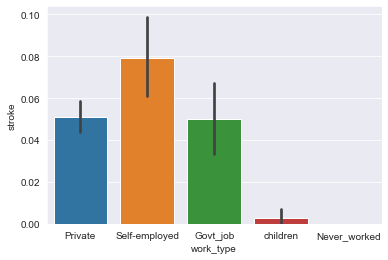

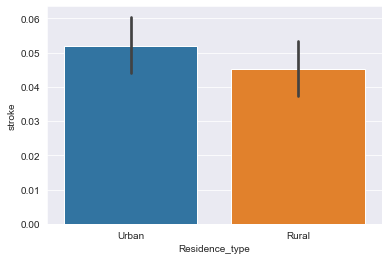

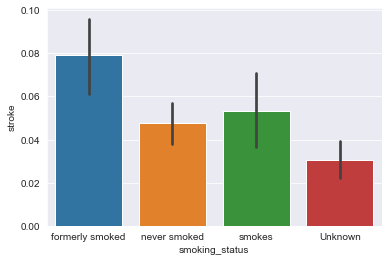

In [70]:
# Visualize correlations between stroke and other categorical variables
for col in cat_cols:
    sns.barplot(data=df, y='stroke', x=col)
    plt.show()

Those who formerly smoked seem to be more likely to have had a stroke than those who have never smoked or are currently smoking. Those who have been married before are also more likely to have had a stroke than those who have never been married. Those who are self-employed also seem to be more likely to have had a stroke than those who have a private or govt. job.

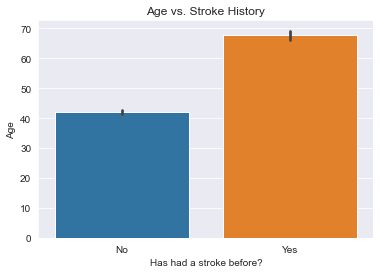

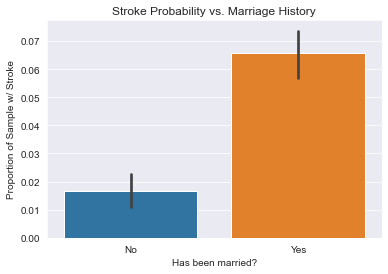

In [71]:
# Create 2 explanatory visualizations
ax1 = sns.barplot(data=df, y='age', x='stroke')
ax1.set_ylabel('Age')
ax1.set_xlabel('Has had a stroke before?')
ax1.set_xticklabels(['No', 'Yes'])
ax1.set_title('Age vs. Stroke History')
plt.show()

ax2 = sns.barplot(data=df, x='ever_married', y='stroke', order=['No', 'Yes'])
ax2.set_ylabel('Proportion of Sample w/ Stroke')
ax2.set_xlabel('Has been married?')
ax2.set_title('Stroke Probability vs. Marriage History')
plt.show()

Those who have had a stroke are around 30 years older than those who have not, on average.

Those who have been married have around a 4x higher probability of having had a stroke than those who have not been married.

In [153]:
# Recreate dataframe to prevent data leakage during modelling
ml_df = pd.read_csv('healthcare-dataset-stroke-data.csv', index_col='id')
ml_df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [154]:
# Check class imbalance
ml_df['stroke'].value_counts(normalize=True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

In [155]:
# Split data into train and test subsets
X = ml_df.drop(columns='stroke')
y = ml_df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [156]:
 # Instantiate median imputer
median_imputer = SimpleImputer(strategy='median')

In [157]:
# Instantiate transformers
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore')

In [158]:
# Create pipeline to impute + scale numerical columns
num_pipe = make_pipeline(median_imputer, scaler)

# Create tuples matching transformations to columns
cat_cols = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
num_cols = ['age', 'avg_glucose_level', 'bmi']

cat_tuple = (ohe, cat_cols)
num_tuple = (num_pipe, num_cols)

# Create final preprocessing object
# ohe categorical columns, impute + scale numerical columns
preprocessor = make_column_transformer(cat_tuple, num_tuple, remainder='drop')

In [159]:
# Define function to evaluate categorical models
def evaluate(y_true, y_preds, y_proba=None):
    print(classification_report(y_true, y_preds))
    ConfusionMatrixDisplay.from_predictions(y_true, y_preds, cmap='Blues')
    if y_proba != None:
        print(roc_auc_score(y_true, y_proba))

In [160]:
# Tune XGBoost model
# Since we are predicting stroke, false negatives are worse than false positives
# scoring metric should be recall
eta = [0.01, 0.03, 0.07, 0.1, 0.2, 0.3]
min_child_weight = [0.5, 1, 2, 3]
max_depth = range(3,10,2)
lambdas = [0, 1]

params = [{'xgbclassifier__eta':eta,
           'xgbclassifier__min_child_weight':min_child_weight,
           'xgbclassifier__max_depth':max_depth,
           'xgbclassifier__lambda':lambdas}]

xgb_pipe = make_pipeline(preprocessor, XGBClassifier())

xgb_gs = GridSearchCV(xgb_pipe,
                      param_grid=params,
                      n_jobs=-1,
                      cv=3,
                      scoring='recall',
                      error_score='raise')
xgb_gs.fit(X_train, y_train)

xgb_gs.best_params_

[19:55:32] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ankit\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


{'xgbclassifier__eta': 0.3,
 'xgbclassifier__lambda': 1,
 'xgbclassifier__max_depth': 5,
 'xgbclassifier__min_child_weight': 2}

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1198
           1       0.40      0.07      0.13        80

    accuracy                           0.94      1278
   macro avg       0.67      0.53      0.55      1278
weighted avg       0.91      0.94      0.91      1278



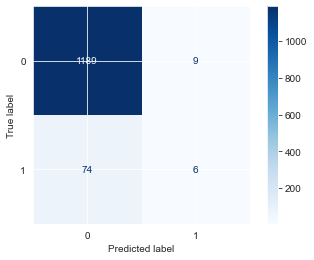

In [161]:
# Evaluate tuned XGBoost model
xgb_tuned = xgb_gs.best_estimator_
evaluate(y_test, xgb_tuned.predict(X_test))

In [162]:
# Tune random forest model
n_estimators = range(50,601,100)
criterion = ['gini', 'entropy']
max_depth = range(3,15,3)
min_samples_split = range(2,20,4)
min_samples_leaf = range(1,20,4)

params = [{'randomforestclassifier__n_estimators': n_estimators,
           'randomforestclassifier__criterion': criterion,
           'randomforestclassifier__max_depth': max_depth,
           'randomforestclassifier__min_samples_split': min_samples_split,
           'randomforestclassifier__min_samples_leaf': min_samples_leaf}]

rf_pipe = make_pipeline(preprocessor, RandomForestClassifier(random_state=42))

rf_gs = GridSearchCV(rf_pipe,
                     param_grid=params,
                     n_jobs=-1,
                     scoring='recall',
                     cv=3)
rf_gs.fit(X_train, y_train)

rf_gs.best_params_

{'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': 12,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 150}

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       1.00      0.03      0.05        80

    accuracy                           0.94      1278
   macro avg       0.97      0.51      0.51      1278
weighted avg       0.94      0.94      0.91      1278



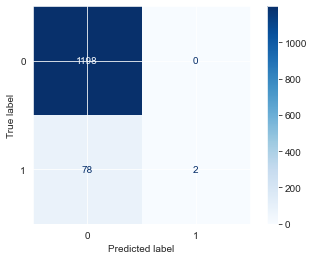

In [163]:
# Evaluate tuned random forest model
rf_tuned = rf_gs.best_estimator_
evaluate(y_test, rf_tuned.predict(X_test))

In [164]:
# Tune KNeighbors model
n_neighbors = range(3,40,5)
weights = ['uniform', 'distance']
leaf_size = range(5,60,10)
p = [1,2]

params = [{'kneighborsclassifier__n_neighbors':n_neighbors,
           'kneighborsclassifier__weights':weights,
           'kneighborsclassifier__leaf_size':leaf_size,
           'kneighborsclassifier__p':p}]

knn_pipe = make_pipeline(preprocessor, KNeighborsClassifier())

knn_gs = GridSearchCV(knn_pipe,
                      param_grid=params,
                      n_jobs=15,
                      scoring='recall',
                      cv=3)
knn_gs.fit(X_train, y_train)

knn_gs.best_params_

{'kneighborsclassifier__leaf_size': 5,
 'kneighborsclassifier__n_neighbors': 3,
 'kneighborsclassifier__p': 1,
 'kneighborsclassifier__weights': 'distance'}

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1198
           1       0.17      0.05      0.08        80

    accuracy                           0.93      1278
   macro avg       0.56      0.52      0.52      1278
weighted avg       0.89      0.93      0.91      1278



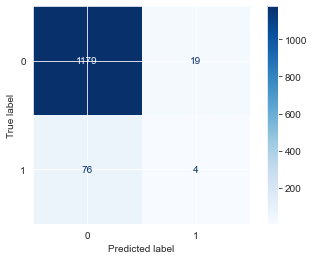

In [165]:
# Evaluate tuned KNN model
knn_tuned = knn_gs.best_estimator_
evaluate(y_test, knn_tuned.predict(X_test))

Out of the 3 models, the tuned XGBoost model had the highest recall of 0.07 with a similar accuracy to the other models of 0.94 (which would be below a dummy model's accuracy of 0.95).

[19:57:06] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ankit\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1198
           1       0.22      0.03      0.04        80

    accuracy                           0.93      1278
   macro avg       0.58      0.51      0.51      1278
weighted avg       0.89      0.93      0.91      1278



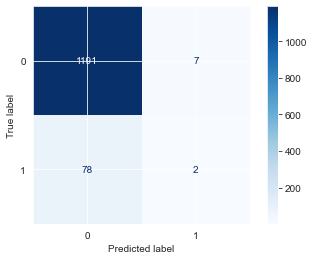

In [166]:
# Evaluate tuned XGBoost model with PCA
pca = PCA(n_components=0.95)
pca_xgb = make_pipeline(preprocessor, pca, XGBClassifier(eta=0.3, reg_lambda=0, max_depth=9, min_child_weight=1))

pca_xgb.fit(X_train, y_train)
evaluate(y_test, pca_xgb.predict(X_test))

PCA reduced the recall of the tuned XGBoost model from 0.07 -> 0.03

False negatives are worse than false positives for stroke predictions, since false negatives lead to a lack of proper treatment and may be dangerous while false positives only lead to an unnecessary checkup.

The recommended production model is the tuned XGBClassifier model, since it had the highest recall of 0.07 with an accuracy similar to the other models of 0.94.

Further research should be conducted before using this model in the real world. A recall of 0.07 is still low for stroke predictions, leading to dangerous false negative errors.